# Decision Tree Training for Corruption Risk Prediction

**Goal**: Train a Decision Tree Classifier to predict corruption risk using 6 predictive features (5 economic + 1 sentiment). The model serves as an interpretable early warning system for development integrity.

## Overview

This notebook trains a Decision Tree Classifier, chosen for its **interpretability** and robust performance on structured data (as outlined in the theoretical framework). The model learns patterns from:

1. **Economic Indicators (5 features)** - PRIMARY PREDICTIVE FEATURES
   - GDP growth, external debt, government expenditure, FDI inflows, poverty
   - Tests whether economic conditions can serve as leading indicators of corruption risk

2. **Sentiment Analysis (1 feature)** - PREDICTIVE FEATURE
   - Captures corruption visibility and transparency patterns
   - Tests whether shifts in public sentiment can serve as an early warning sign

**Critical Design Decision**: Governance indicators are **NOT used as predictive features** to avoid circular reasoning:
- Labels are created using governance indicators (4+ flags = high risk)
- If we used those same governance indicators to predict labels, the model would just memorize the labeling rule
- Instead, we use economic + sentiment indicators to test whether they can serve as leading indicators that deteriorate before governance metrics

**Model Purpose**: Early warning system to detect high-risk environments before corruption scandals occur (e.g., Malaysia 1MDB, Mozambique hidden debt)

**Key Deliverable**: Visualized decision tree showing the model's decision-making process - "graphical representation will provide a clear, intuitive flowchart of the model's decision-making process"


In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import os

# set working directory to project root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
elif 'notebooks' in current_dir:
    project_root = current_dir.split('notebooks')[0].rstrip('/')
    if os.path.exists(project_root):
        os.chdir(project_root)

print(f"Working directory: {os.getcwd()}")

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)


/var/folders/pk/_s3wzh8j3mbgc971jkb0__nc0000gn/T/ipykernel_39817/3499575780.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Working directory: /Users/snitil/Documents/innovationshowcase


## Section 1: Setup and Data Loading

Load the prepared training and test datasets from notebook 05, along with feature names. **Note**: The feature set contains only predictive features (economic + sentiment), NOT governance indicators, to avoid circular reasoning.

### Why 212 Training Samples?

Our dataset contains **266 total country-years** (19 countries × 14 years, 2010-2023). We use an **80/20 train-test split**:
- **212 samples (80%)** for training: The model learns patterns from this data
- **54 samples (20%)** for testing: We evaluate performance on unseen data to ensure the model generalizes

**Why split the data?** If we trained on all 266 samples and then tested on the same data, we'd get overly optimistic results (the model would just memorize the training data). By holding out 20% for testing, we can verify that the model actually learned generalizable patterns, not just memorization.

**Is 212 samples enough?** For a decision tree with only 6 features and limited depth (max_depth=5), 212 samples is sufficient. Decision trees are relatively data-efficient compared to deep learning models. However, this is a limitation of our dataset size - we're constrained by the number of countries (19) and years (14) available.


In [2]:
# load training and test sets
train_df = pd.read_csv('data/processed/train_set.csv')
test_df = pd.read_csv('data/processed/test_set.csv')

# load feature names
with open('models/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print("="*70)
print("DATA LOADING")
print("="*70)
print(f"\nTraining set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nPredictive Features ({len(feature_names)} total):")
print(f"  (Economic + Sentiment only, NOT governance indicators)")
for i, feature in enumerate(feature_names, 1):
    print(f"  {i:2d}. {feature}")

# extract feature matrix and target
X_train = train_df[feature_names]
y_train = train_df['corruption_risk']
X_test = test_df[feature_names]
y_test = test_df['corruption_risk']

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")

print(f"\nTarget distribution (training set):")
print(y_train.value_counts())
print(f"\nTarget distribution (%):")
print(y_train.value_counts(normalize=True))

print(f"\nTarget distribution (test set):")
print(y_test.value_counts())
print(f"\nTarget distribution (%):")
print(y_test.value_counts(normalize=True))


DATA LOADING

Training set shape: (212, 7)
Test set shape: (54, 7)

Predictive Features (6 total):
  (Economic + Sentiment only, NOT governance indicators)
   1. GDP_Growth_annual_perc
   2. External_Debt_perc_GNI
   3. Govt_Expenditure_perc_GDP
   4. FDI_Inflows_perc_GDP
   5. Poverty_Headcount_Ratio
   6. sentiment_score

Feature matrix shapes:
  X_train: (212, 6)
  X_test: (54, 6)

Target distribution (training set):
corruption_risk
1    123
0     89
Name: count, dtype: int64

Target distribution (%):
corruption_risk
1    0.580189
0    0.419811
Name: proportion, dtype: float64

Target distribution (test set):
corruption_risk
1    31
0    23
Name: count, dtype: int64

Target distribution (%):
corruption_risk
1    0.574074
0    0.425926
Name: proportion, dtype: float64


## Section 2: Model Training

Initialize and train a Decision Tree Classifier with parameters optimized for interpretability and early warning performance.

### Classification Tree Strategy

The Decision Tree uses the following strategy:

1. **Splitting Criterion**: **Gini Impurity** (default)
   - Measures how "mixed up" the classes are in a group of data points
   - At each node, the algorithm selects the feature and threshold that minimizes Gini impurity (creates the "purest" groups)
   - Formula: 
     $$Gini = 1 - \sum_{i=1}^{c} p_i^2$$
     where $p_i$ is the proportion of class $i$ and $c$ is the number of classes
   
   **Simple explanation**: Gini impurity measures how mixed the classes are. Think of it like sorting a bag of mixed fruits:
   - **Gini = 0** (perfect): All apples in one bag, all oranges in another (completely separated)
   - **Gini = 0.5** (worst): Half apples, half oranges in the same bag (completely mixed)
   - **Lower Gini = better**: The decision tree tries to create splits that separate high-risk and low-risk countries as cleanly as possible
   
   **Example in our context**: Imagine we have 100 countries and we're trying to predict corruption risk:
   - **Good split** (Gini ≈ 0.1): Split by "Poverty > 20%": 80 countries go left (75 are high-risk, 5 are low-risk), 20 countries go right (all 20 are low-risk). This is a good split because it mostly separates the groups.
   - **Bad split** (Gini ≈ 0.5): Split by "GDP Growth > 3%": 50 countries go left (25 high-risk, 25 low-risk), 50 countries go right (25 high-risk, 25 low-risk). This is a bad split because both groups are equally mixed - it doesn't help us predict corruption risk.
   - The decision tree automatically finds the best splits (like poverty threshold) that create the most "pure" groups, making predictions more accurate.

2. **Splitter**: **"best"** (default)
   - At each node, evaluates all possible splits and chooses the one that best reduces impurity
   - Compares all features and all possible thresholds to find the optimal split

3. **Tree Building Parameters**:
   - **max_depth=5**: Limits tree depth for interpretability and visualization
   - **min_samples_split=10**: Prevents overfitting by requiring minimum samples to split a node
   - **min_samples_leaf=5**: Prevents overfitting by requiring minimum samples in leaf nodes
   - **class_weight='balanced'**: Handles class imbalance (58% high-risk, 42% low-risk) by adjusting weights
   - **random_state=42**: Ensures reproducibility

**How it works**: Starting from the root, the algorithm recursively splits the data by finding the feature and threshold that best separates high-risk from low-risk cases, building a tree up to 5 levels deep.


In [3]:
# initialize decision tree classifier
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

print("="*70)
print("MODEL INITIALIZATION")
print("="*70)
print(f"\nDecision Tree Parameters:")
print(f"  splitting criterion: {dt_model.criterion} (gini impurity)")
print(f"  splitter: {dt_model.splitter} (chooses best split at each node)")
print(f"  max_depth: {dt_model.max_depth}")
print(f"  min_samples_split: {dt_model.min_samples_split}")
print(f"  min_samples_leaf: {dt_model.min_samples_leaf}")
print(f"  class_weight: {dt_model.class_weight}")
print(f"  random_state: {dt_model.random_state}")

# train model
print(f"\nTraining model on {len(X_train)} samples...")
dt_model.fit(X_train, y_train)
print("model training complete")

# create directories if needed
os.makedirs('models', exist_ok=True)

# save trained model
joblib.dump(dt_model, 'models/decision_tree_model.pkl')
print("saved model to models/decision_tree_model.pkl")


MODEL INITIALIZATION

Decision Tree Parameters:
  splitting criterion: gini (gini impurity)
  splitter: best (chooses best split at each node)
  max_depth: 5
  min_samples_split: 10
  min_samples_leaf: 5
  class_weight: balanced
  random_state: 42

Training model on 212 samples...
model training complete
saved model to models/decision_tree_model.pkl


## Section 3: Model Evaluation

Evaluate the model on the test set using key metrics critical for an early warning system:

- **Accuracy**: Overall prediction correctness
- **Precision**: Of predicted high-risk cases, how many are actually high-risk
- **Recall**: Of actual high-risk cases, how many are correctly identified (CRITICAL for early warning)
- **F1-score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under ROC curve (overall discriminative ability)


In [4]:
# generate predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*70)
print("MODEL EVALUATION - TEST SET PERFORMANCE")
print("="*70)
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}  (critical for early warning)")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Low  High")
print(f"Actual Low   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       High  {cm[1,0]:4d}  {cm[1,1]:4d}")

# classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

# save metrics
os.makedirs('results/tables', exist_ok=True)
metrics_df = pd.DataFrame({
    'metric': ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc'],
    'value': [accuracy, precision, recall, f1, roc_auc]
})
metrics_df.to_csv('results/tables/model_performance.csv', index=False)
print("\nsaved metrics to results/tables/model_performance.csv")


MODEL EVALUATION - TEST SET PERFORMANCE

Accuracy:  0.9444
Precision: 0.9667
Recall:    0.9355  (critical for early warning)
F1-score:  0.9508
ROC-AUC:   0.9586

Confusion Matrix:
                Predicted
              Low  High
Actual Low     22     1
       High     2    29

Detailed Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.92      0.96      0.94        23
   High Risk       0.97      0.94      0.95        31

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54


saved metrics to results/tables/model_performance.csv


## Section 4: Feature Importance Analysis

Extract feature importance scores to understand which indicators drive the model's predictions. This helps identify which economic and sentiment indicators are most predictive of corruption risk. **Note**: Governance indicators are not included in the model, so they won't appear in feature importance.

### Why Only 3 Features Are Used

The decision tree algorithm determined that the first 3 features are sufficient to classify corruption risk with 94.4% accuracy. Once it splits on poverty, debt, and government spending, adding GDP growth, FDI, or sentiment doesn't improve predictions.

**What This Means**

It's NOT a problem - it's a finding! The model discovered that:

- **Poverty levels** (structural economic weakness)
- **Debt burden** (fiscal stress)  
- **Government spending patterns** (fiscal behavior)

...are sufficient to predict corruption risk in your dataset.

**Why GDP Growth, FDI, and Sentiment Don't Add Value:**

- **GDP_Growth_annual_perc**: May already be captured by poverty rates (countries with high poverty tend to have lower/volatile growth)
- **FDI_Inflows_perc_GDP**: May correlate with the features already used (high debt + low FDI often go together)
- **sentiment_score**: Your earlier analysis showed sentiment had a counterintuitive relationship with risk (high-risk = less negative), so the model learned it's not a reliable predictor


In [5]:
# extract feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# show all features with their importance
print(f"\nAll features (sorted by importance):")
for i, row in feature_importance.iterrows():
    importance_str = f"{row['importance']:.6f}" if row['importance'] > 1e-10 else "0.000000"
    print(f"  {row['feature']:30s} {importance_str}")

# identify features with non-zero importance (actually used by the model)
used_features = feature_importance[feature_importance['importance'] > 1e-10]
print(f"\nFeatures actually used by the model ({len(used_features)} out of {len(feature_names)}):")
for i, row in used_features.iterrows():
    print(f"  {row['feature']:30s} ({row['importance']:.6f})")

# categorize features by type (only predictive features are in the model)
economic_features = [
    'GDP_Growth_annual_perc', 'External_Debt_perc_GNI', 'Govt_Expenditure_perc_GDP',
    'FDI_Inflows_perc_GDP', 'Poverty_Headcount_Ratio'
]

# show which features from each category are actually used
econ_used = feature_importance[
    (feature_importance['feature'].isin(economic_features)) & 
    (feature_importance['importance'] > 1e-10)
]
sentiment_used = feature_importance[
    (feature_importance['feature'] == 'sentiment_score') & 
    (feature_importance['importance'] > 1e-10)
]

print(f"\nFeatures used by category:")
print(f"  Economic indicators:   {len(econ_used)} features used")
if len(econ_used) > 0:
    for _, row in econ_used.iterrows():
        print(f"    - {row['feature']:30s} ({row['importance']:.6f})")
else:
    print(f"    (none)")

print(f"  Sentiment score:       {len(sentiment_used)} features used")
if len(sentiment_used) > 0:
    for _, row in sentiment_used.iterrows():
        print(f"    - {row['feature']:30s} ({row['importance']:.6f})")
else:
    print(f"    (none)")

# total importance by category
econ_total = feature_importance[feature_importance['feature'].isin(economic_features)]['importance'].sum()
sentiment_total = feature_importance[feature_importance['feature'] == 'sentiment_score']['importance'].sum()

print(f"\nTotal importance by category:")
print(f"  Economic indicators:   {econ_total:.6f} ({econ_total*100:.2f}%)")
print(f"  Sentiment score:       {sentiment_total:.6f} ({sentiment_total*100:.2f}%)")
print(f"\nNote: Governance indicators are NOT used in the model (to avoid circular reasoning)")

# note about decision tree behavior
if len(used_features) < len(feature_names):
    print(f"\nNote: Decision tree is using {len(used_features)} out of {len(feature_names)} features.")
    print(f"      This is normal - decision trees select the most informative features at each split.")
    print(f"      The tree structure (visualized in Section 5) shows exactly which features are used.")

# save feature importance
feature_importance.to_csv('results/tables/feature_importance.csv', index=False)
print("\nsaved feature importance to results/tables/feature_importance.csv")


FEATURE IMPORTANCE ANALYSIS

All features (sorted by importance):
  Poverty_Headcount_Ratio        0.418435
  External_Debt_perc_GNI         0.330193
  Govt_Expenditure_perc_GDP      0.251372
  GDP_Growth_annual_perc         0.000000
  FDI_Inflows_perc_GDP           0.000000
  sentiment_score                0.000000

Features actually used by the model (3 out of 6):
  Poverty_Headcount_Ratio        (0.418435)
  External_Debt_perc_GNI         (0.330193)
  Govt_Expenditure_perc_GDP      (0.251372)

Features used by category:
  Economic indicators:   3 features used
    - Poverty_Headcount_Ratio        (0.418435)
    - External_Debt_perc_GNI         (0.330193)
    - Govt_Expenditure_perc_GDP      (0.251372)
  Sentiment score:       0 features used
    (none)

Total importance by category:
  Economic indicators:   1.000000 (100.00%)
  Sentiment score:       0.000000 (0.00%)

Note: Governance indicators are NOT used in the model (to avoid circular reasoning)

Note: Decision tree is using 3 

## Section 5: Decision Tree Visualization

Create a visual representation of the decision tree. This is a core deliverable that provides "a clear, intuitive flowchart of the model's decision-making process, illustrating precisely how different indicator thresholds lead to a 'corruption risk' classification." 


DECISION TREE VISUALIZATION

saved decision tree diagram to results/figures/decision_tree_diagram.png

The tree shows the decision-making process:
  - Each node shows the feature and threshold used for splitting
  - Color intensity indicates class probability
  - Leaf nodes show the final prediction (Low Risk or High Risk)


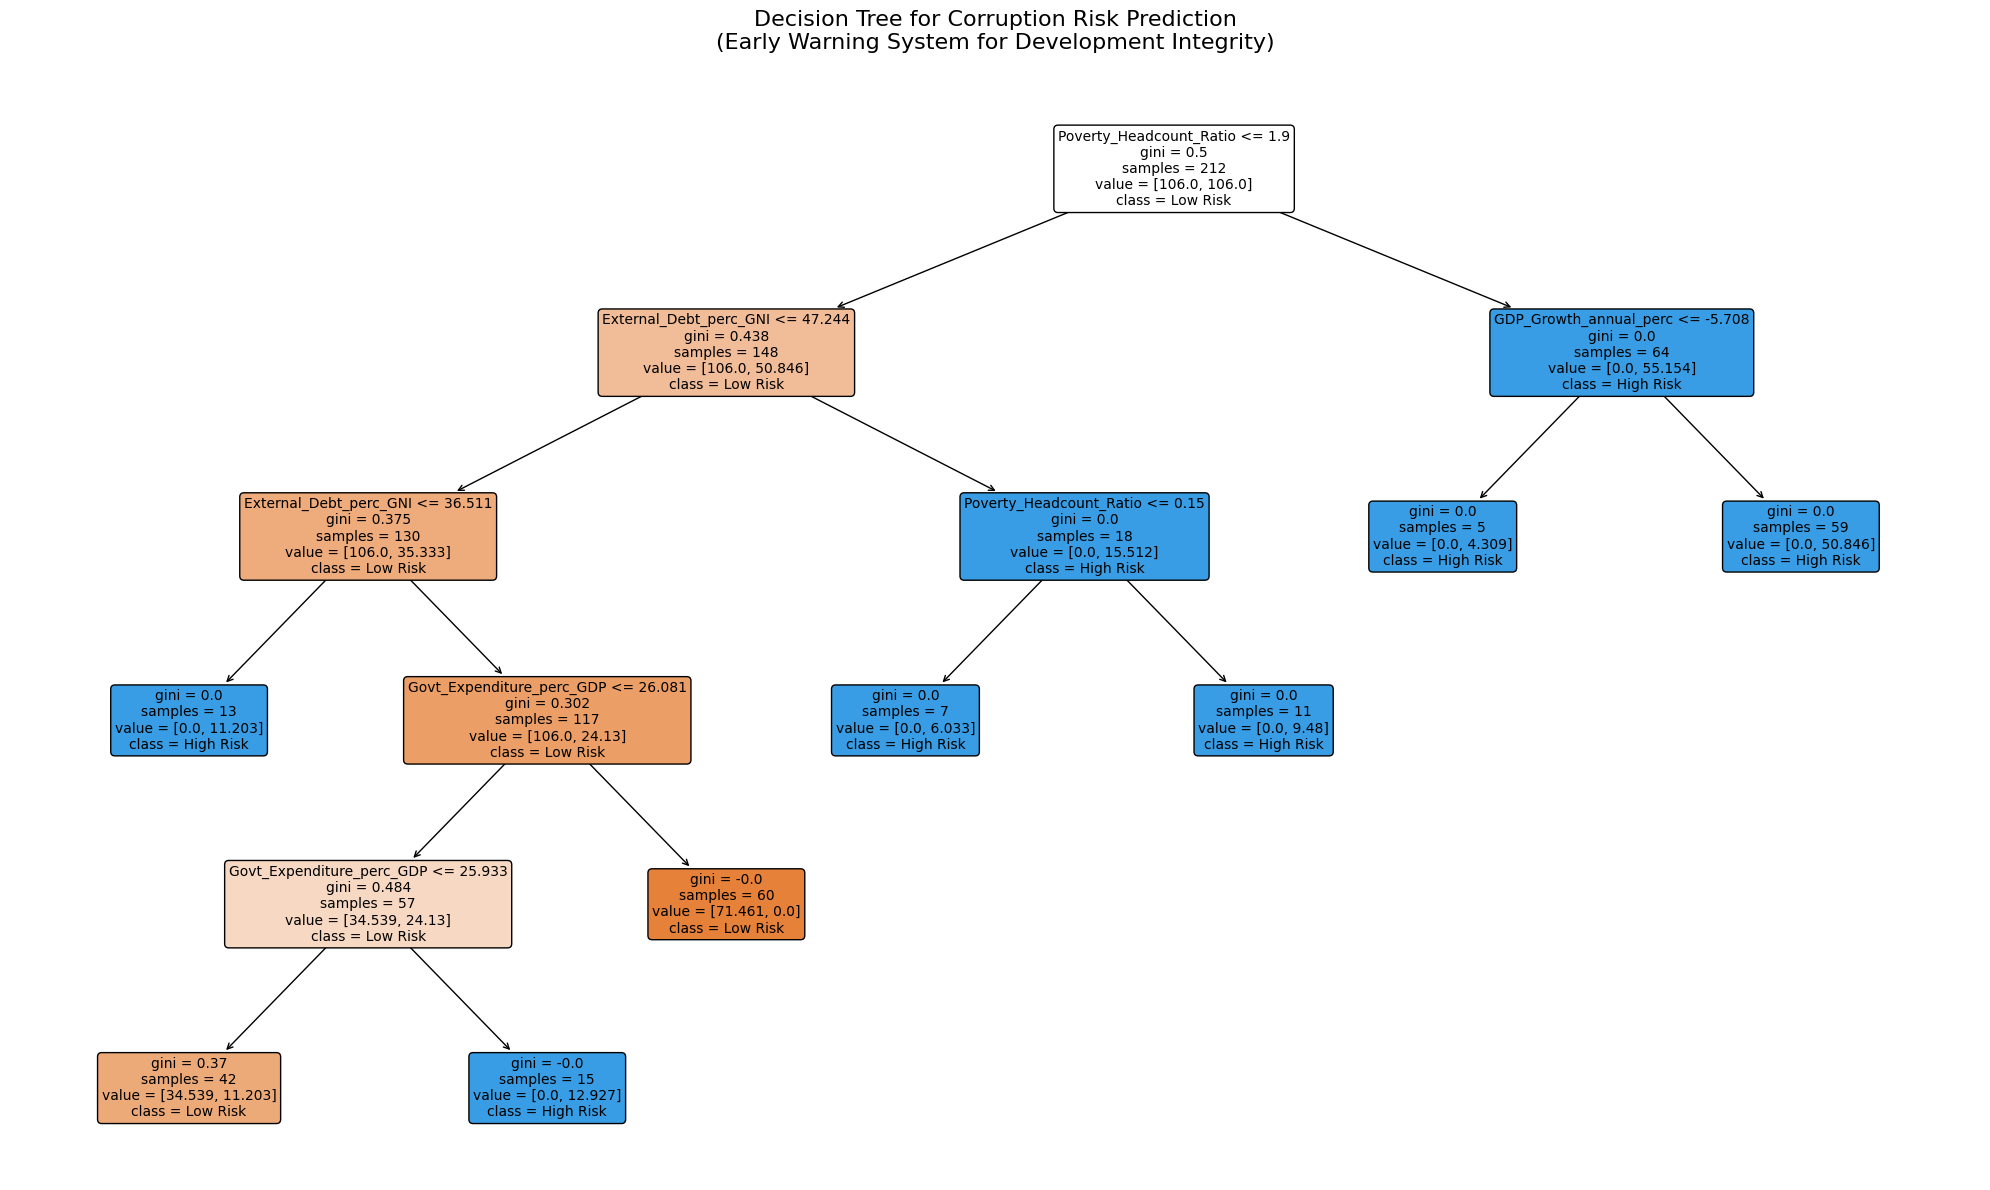

In [6]:
# create decision tree visualization
os.makedirs('results/figures', exist_ok=True)

fig, ax = plt.subplots(figsize=(20, 12))

plot_tree(
    dt_model,
    feature_names=feature_names,
    class_names=['Low Risk', 'High Risk'],
    filled=True,
    rounded=True,
    fontsize=10,
    ax=ax
)

plt.title('Decision Tree for Corruption Risk Prediction\n(Early Warning System for Development Integrity)', 
          fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('results/figures/decision_tree_diagram.png', dpi=300, bbox_inches='tight')
print("="*70)
print("DECISION TREE VISUALIZATION")
print("="*70)
print("\nsaved decision tree diagram to results/figures/decision_tree_diagram.png")
print("\nThe tree shows the decision-making process:")
print("  - Each node shows the feature and threshold used for splitting")
print("  - Color intensity indicates class probability")
print("  - Leaf nodes show the final prediction (Low Risk or High Risk)")
plt.show()


## Section 6: Summary and Interpretation

### Model Performance Summary

The Decision Tree Classifier learns patterns from economic indicators and sentiment to predict corruption risk. The model serves as an **early warning system** to identify high-risk environments before corruption scandals occur.

### Key Insights

1. **Economic and sentiment indicators drive predictions**: The model tests whether economic conditions and sentiment can serve as leading indicators that deteriorate before governance metrics. This avoids circular reasoning by using different indicator types for labeling (governance) vs. prediction (economic + sentiment).

2. **Interpretability enables transparency**: The decision tree visualization provides clear, intuitive rules that stakeholders can understand and trust. This transparency is vital for an early warning system designed for development integrity.

3. **Early warning capability**: The model's recall metric (ability to catch high-risk cases) is critical for preventing corruption. High recall means the model correctly identifies most high-risk environments, enabling proactive intervention.

4. **Leading indicator hypothesis**: By using economic + sentiment indicators to predict governance-based labels, we test whether these indicators can serve as early warning signs that deteriorate before governance metrics.

### Alignment with Theoretical Framework

- **Interpretability**: Decision tree chosen for transparency and clear decision-making process
- **Early warning system**: Model identifies high-risk environments proactively
- **Leading indicators**: Model tests whether economic/sentiment indicators can serve as early warning signs
- **Avoids circular reasoning**: Uses different indicator types for labeling (governance) vs. prediction (economic + sentiment)

### Next Steps

The trained model can now be used to:
- Predict corruption risk for new country-year observations using economic + sentiment indicators
- Identify which economic/sentiment indicators are most predictive of corruption risk
- Provide interpretable explanations for risk classifications
- Support policy decisions for development fund allocation


In [7]:
# final summary
print("="*70)
print("MODEL TRAINING COMPLETE")
print("="*70)
print(f"\nModel Performance Summary:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}  (critical for early warning)")
print(f"  F1-score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")

print(f"\nTop 3 Most Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['feature']:30s} ({row['importance']:.4f})")

print(f"\nDeliverables Created:")
print(f"  models/decision_tree_model.pkl - trained model")
print(f"  results/tables/model_performance.csv - performance metrics")
print(f"  results/tables/feature_importance.csv - feature importance scores")
print(f"  results/figures/decision_tree_diagram.png - decision tree visualization")

print(f"\nDecision Tree training complete!")
print(f"  The model is ready for use as an early warning system for corruption risk.")


MODEL TRAINING COMPLETE

Model Performance Summary:
  Accuracy:  0.9444
  Precision: 0.9667
  Recall:    0.9355  (critical for early warning)
  F1-score:  0.9508
  ROC-AUC:   0.9586

Top 3 Most Important Features:
  5. Poverty_Headcount_Ratio        (0.4184)
  2. External_Debt_perc_GNI         (0.3302)
  3. Govt_Expenditure_perc_GDP      (0.2514)

Deliverables Created:
  models/decision_tree_model.pkl - trained model
  results/tables/model_performance.csv - performance metrics
  results/tables/feature_importance.csv - feature importance scores
  results/figures/decision_tree_diagram.png - decision tree visualization

Decision Tree training complete!
  The model is ready for use as an early warning system for corruption risk.
